In [86]:
# IMPORTS
# Math for the ceiling function
from math import ceil
# Matplotlib for graphing capabilities
from matplotlib import pyplot as plt
# Modules from the Autograd library for creating neural networks
import autograd.numpy as np
from autograd import grad 
import autograd.numpy.random as npr



## Support Function

The below two code cells define a function that calcualtes the root mean-squared error between two NumPy arrays (for error analysis) and the two common actication functions for neural networks.

In [87]:
def rmse(A,B):
    return np.sqrt(np.average((A-B)**2)) 

In [88]:
def sigmoid(x):
    return 1. / (1. + np.exp(-x))

def tanh(x):
    return np.tanh(x)   

## Defining the Model

In [89]:
def velocity_verlet (b,m,DeltaT,tfinal):
    g = -9.81

    # set up arrays 
    n = ceil(tfinal/DeltaT) #Assuming tinitial=0

    # set up arrays for t, a, v, and y and we can compare our results with analytical ones
    t = np.zeros(n)
    a = np.zeros(n)
    v = np.zeros(n)
    y_vv = np.zeros(n)

    # Initial conditions (Change these if needed)
    v[0] = 0.0  #m/s
    y_vv[0] = 0.0 #m

    # Start integrating using Euler-Cromer
    for i in range(n-1):
        # expression for acceleration
        a[i] = g - (b/m)*v[i]
        # update position
        y_vv[i+1] = y_vv[i] + v[i]*DeltaT + 0.5*a[i]*DeltaT**2
        # updated expression for acceleration
        a[i+1] = g - (b/m)*v[i+1]
        # update velocity
        v[i+1] = v[i] + 0.5*DeltaT*(a[i+1] + a[i])
        # update time to next time step and compute analytical answer
        t[i+1] = t[i] + DeltaT

    return y_vv

In [90]:
def y_analytic(t,b,m):
    '''
        Analytical solution of current problem
    '''
   # Define the gravitational constant
    g = -9.81

    # Set up the initial conditions (velocity and height)
    v_0 = 0
    y_0 = 0

    # Define the termminal velocity and the characteristic time
    v_ter = m*g/b
    tau = v_ter/g

    # Define the exact solution
    y_exact = v_ter*t + (v_0-v_ter)*tau*(1-np.exp(-t/tau))+y_0
    return y_exact

In [91]:
def f(t, y, v):
    '''
        d2(x)/dt2 = f(t, v, x)
        This is f() function on the right
    '''
    return -9.81-b*v

In [92]:
b = 0.001
m = 1.0
nt = 25
tfinal = 2
dt = tfinal / nt
t = np.linspace(0, tfinal, nt)    
y_exact = y_analytic(t,b,m)
y_vv = velocity_verlet (b,m,dt,2)

## Creating the Neural Networks

In [93]:
def neural_network(W, x):
    a1 = sigmoid(np.dot(x, W[0]))
    return np.dot(a1, W[1])

def neural_network_x(x):
    a1 = sigmoid(np.dot(x, W[0]))
    return np.dot(a1, W[1])

In [94]:
def y_trial(ti, net_out):
    return ti + ti**2 * net_out
v = grad(y_trial)
a = grad(v)

## Defining the Loss Function

In [95]:
def loss_function(W, t):
    loss_sum = 0.
    
    for ti in t:
        net_out = neural_network(W, ti)[0][0]
        net_out_d = grad(neural_network_x)(ti)
        net_out_dd = grad(grad(neural_network_x))(ti)
        
        y_t = y_trial(ti, net_out)
        v_t = v(ti, net_out)
        a_t = a(ti, net_out)
        
        func = f(ti, y_t, v_t) # right part function
        
        err_sqr = (a_t - func)**2
        loss_sum += err_sqr
        
    return loss_sum

## Training the Network and Analyzing the Results

In [96]:
W = [npr.randn(1, 10), npr.randn(10, 1)]

learning_rate = 0.001
num_training_iterations = 25

for i in range(num_training_iterations):
    loss_grad =  grad(loss_function)(W, t)

    W[0] = W[0] - learning_rate * loss_grad[0]
    W[1] = W[1] - learning_rate * loss_grad[1]

res = [y_trial(ti, neural_network(W, ti)[0][0]) for ti in t] 


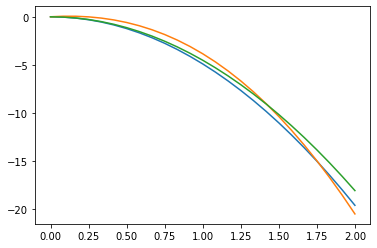

In [97]:

plt.figure()
plt.plot(t, y_exact) 
plt.plot(t, res)
plt.plot(t,y_vv)
plt.show()

In [98]:
rmse(y_vv,y_exact),rmse(y_exact,res)

(0.70630900830357, 0.7140190353860018)

## Improving the Accuracy of the Neural Network

In [101]:
best_err = 100
best_lr = None
best_num = None
for lr in [0.0001, 0.001, 0.01, 0.1, 1.0]:
    for num in [25, 50, 75, 100]:
        W = [npr.randn(1, 10), npr.randn(10, 1)]

        for i in range(num_training_iterations):
            loss_grad =  grad(loss_function)(W, t)

            W[0] = W[0] - learning_rate * loss_grad[0]
            W[1] = W[1] - learning_rate * loss_grad[1]

        res = [y_trial(ti, neural_network(W, ti)[0][0]) for ti in t] 
        err = rmse(y_exact,res)
        print("Hyperparameter Combination and Error: (",lr, num,")",err)
        if err < best_err:
            best_err = err
            best_lr = lr
            best_num = num
print("Best Hyperparameter Combination and Error: (",best_lr, best_num,")",best_err)          

Hyperparameter Combination and Error: ( 0.0001 25 ) 0.8227944429554523
Hyperparameter Combination and Error: ( 0.0001 50 ) 1.004816855095142
Hyperparameter Combination and Error: ( 0.0001 75 ) 0.9849865774155556
Hyperparameter Combination and Error: ( 0.0001 100 ) 0.7765932669738814
Hyperparameter Combination and Error: ( 0.001 25 ) 0.8638541283046582
Hyperparameter Combination and Error: ( 0.001 50 ) 0.8088922151496122
Hyperparameter Combination and Error: ( 0.001 75 ) 0.7709801200338442
Hyperparameter Combination and Error: ( 0.001 100 ) 0.8718528518312246
Hyperparameter Combination and Error: ( 0.01 25 ) 0.9890645518659852
Hyperparameter Combination and Error: ( 0.01 50 ) 0.7473426113446987
Hyperparameter Combination and Error: ( 0.01 75 ) 0.5895758350872099
Hyperparameter Combination and Error: ( 0.01 100 ) 1.0264451463105622
Hyperparameter Combination and Error: ( 0.1 25 ) 1.1471414569491438
Hyperparameter Combination and Error: ( 0.1 50 ) 0.7750592412748556
Hyperparameter Combina

## Practice What You Have Learned